# Questão 5 - Navier-Stokes

Visto que não chegamos a explorar bem as equações de Navier-Stokes. Fui atrás de fontes para entender a abordagem, com isso vi para resolver numericamente esse sistema de equações, é preciso implementar um esquema de diferenças finitas no espaço e no tempo. Existem vários métodos numéricos disponíveis para isso, como o método de diferenças finitas explícitas ou implícitas para o tempo e a discretização central para as derivadas espaciais. 

Dessa forma segui a explicação de [nbviewer.org](https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/14_Step_11.ipynb) para Cavity Flow with Navier–Stokes

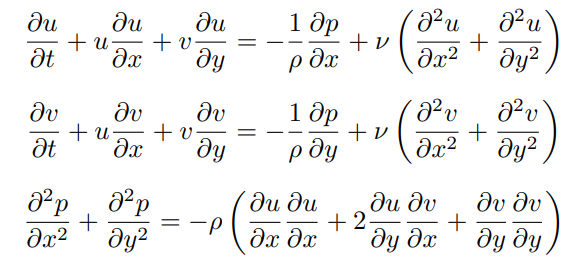

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

## Parâmetros

In [22]:
# Parâmetros
nt = 700  # Número de etapas de tempo
nit = 50  # Número de iterações para a Pressão de Poisson
rho = 1.0  # Densidade do fluido
nu = 0.1  # Viscosidade cinemática do fluido
dt = 0.001  # Intervalo de tempo por etapa

#malha
nx, ny = 41, 41
dx, dy = 2.0 / (nx - 1), 2.0 / (ny - 1)

#condições iniciais/contorno
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))

#"tampa"
u[:, -1] = 1.0
u[:, 0] = 0.0
u[0, :] = 0.0
u[-1, :] = 0.0
v[0, :] = 0.0
v[-1, :] = 0.0

Aqui são aplicadas as equações de naiver-stokes e a de Poisson para a pressão, juntamente com a atualização das velocidade conforme a pressão obtida

In [25]:
#método de diferenças finitas
for n in range(nt):
    un, vn, pn = u.copy(), v.copy(), p.copy()
    #Navier-Stokes
    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     dt/dx * un[1:-1, 1:-1] * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     dt/dy * vn[1:-1, 1:-1] * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) +
                     nu * (dt/dx**2 * (un[1:-1, 2:] - 2*un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                           dt/dy**2 * (un[2:, 1:-1] - 2*un[1:-1, 1:-1] + un[0:-2, 1:-1])) -
                     dt/(2*rho*dx) * (pn[1:-1, 2:] - pn[1:-1, 0:-2]))

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     dt/dx * un[1:-1, 1:-1] * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     dt/dy * vn[1:-1, 1:-1] * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) +
                     nu * (dt/dx**2 * (vn[1:-1, 2:] - 2*vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                           dt/dy**2 * (vn[2:, 1:-1] - 2*vn[1:-1, 1:-1] + vn[0:-2, 1:-1])) -
                     dt/(2*rho*dy) * (pn[2:, 1:-1] - pn[0:-2, 1:-1]))

    #velocidade
    u[:, 0], u[0, :], u[-1, :], v[0, :], v[-1, :] = 0.0, 0.0, 0.0, 0.0, 0.0

    # Equação de Poisson - pressão
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                         (2*(dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * rho *
                         (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2*dx) +
                                     (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2*dy)) -
                          ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2*dx))**2 -
                          2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2*dy) *
                               (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2*dx)) -
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2*dy))**2))

        #condições de contorno para pressão
        p[:, -1] = p[:, -2]  # dp/dx = 0 em x = 2
        p[0, :] = p[1, :]  # dp/dy = 0 em y = 0
        p[-1, :] = 0.0  # p = 0 em y = 2
        p[:, 0] = p[:, 1]  # dp/dx = 0 em x = 0

    #update velocidade com a pressão corrigida
    u[1:-1, 1:-1] -= dt / dx * (p[1:-1, 2:] - p[1:-1, 0:-2]) / (2*rho)
    v[1:-1, 1:-1] -= dt / dy * (p[2:, 1:-1] - p[0:-2, 1:-1]) / (2*rho)

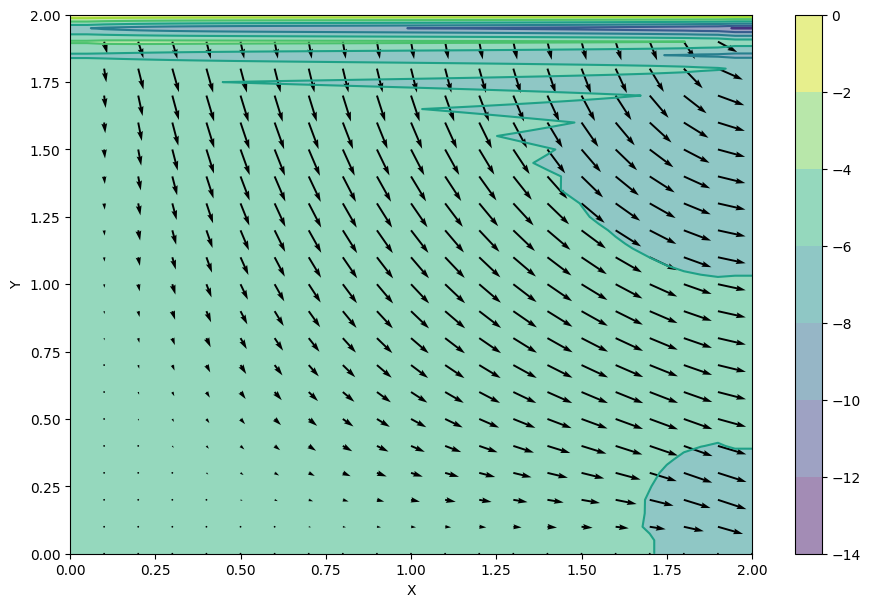

In [26]:
X, Y = np.meshgrid(np.linspace(0, 2, nx), np.linspace(0, 2, ny))
fig = plt.figure(figsize=(11, 7), dpi=100)
plt.contourf(X, Y, p, alpha=0.5, cmap='viridis')
plt.colorbar()
plt.contour(X, Y, p, cmap='viridis')
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()